In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

from shapely.geometry import Polygon
from osgeo import gdal

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.sp_utils as sp


In [3]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [4]:
# Constants
BANDS = [
        'B1: Aerosols',
        'B2: Blue',
        'B3: Green',
        'B4: Red',
        'B5: Red Edge 1',
        'B6: Red Edge 2',
        'B7: Red Edge 3',
        'B8: NIR',
        'B8A: Red Edge 4',
        'B9: Water Vapor',
        'B11: SWIR 1',
        'B12: SWIR 2'
    ]

UMP = ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
       'height_max', 'height_percentile', 'planar_index', 'frontal_index']

In [5]:
# Import train and validation
with open("data/x_train_tokyo.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    y_val = pickle.load(f)

print("Types:", x_train.dtype, x_train.dtype, x_val.dtype, y_val.dtype)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}\nx_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

Types: float32 float32 float32 float32
x_train shape: (2628, 12, 91, 91), y_train shape: (2628, 8)
x_val shape: (614, 12, 91, 91), y_val shape: (614, 8)


In [6]:
from utils.models import senet
from utils.models import modules
from utils.models import net


### Normalising x and y

Normalisation will only be fitted on the training set, and the same parameters will be used for the validation sets

In [7]:
class NDNormalizer:
    def __init__(self, x):
        self.min_x = x.min()
        self.max_x = x.max()
    
    def transform(self, new_x):
        return new_x / self.max_x

    def revert(self, new_x):
        return new_x * self.max_x



In [8]:
x_norms = []
x_train_norm = np.array(x_train)
for channel in range(x_train.shape[1]):
    x_norms.append(NDNormalizer(x_train[:, channel]))
    # x_norms.append(MinMaxScaler().fit(x_train[:, channel]))
    x_train_norm[:, channel] = x_norms[channel].transform(x_train[:, channel])

In [9]:
y_norms = []
y_train_norm = np.array(y_train)
for ump in range(y_train.shape[1]):
    y_norms.append(NDNormalizer(y_train[:, ump]))
    y_train_norm[:, ump] = y_norms[ump].transform(y_train[:, ump])

In [10]:
BATCH_SIZE = 5

In [11]:
# DataLoaders for 3 channels in gpu

# Converts into dataloaders
dls_3 = DataLoaders().from_dsets(list(zip(x_train[:, 1:4], y_train)), list(zip(x_val[:, 1:4], y_val)), 
    bs= BATCH_SIZE, device=torch.device('cuda'))

# Check shape
dls_3.one_batch()[0].shape, dls_3.one_batch()[1].shape

(torch.Size([5, 3, 91, 91]), torch.Size([5, 8]))

In [12]:
# ssl to facilitate downloading of weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# This is not ideal since we're only working with one feature but we'll try to make it work first
head = create_head(8, 8, ps=0.5)
original_model = senet.senet154()

# original_model = pretrainedmodels.__dict__["sene154"](num_classes=1000, pretrained='imagenet')
# original_model = xse_resnet18() # Check whether it lines up with the number of blockst too
Encoder = modules.E_senet(original_model, x_norms)
model = net.model(Encoder, head, num_features=2048, block_channel = [256, 512, 1024, 2048])


In [13]:
# Loss Function

def mse_weighted(pred, actual, y_norms:List[NDNormalizer]= y_norms):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), y_norms[ump].max_x**2))
    return loss.float()


In [14]:
# List of metrics
def height_avg_bld_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def height_avg_area_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def height_avg_total_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

def height_std_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def height_max_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def height_percentile_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def planar_index_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def frontal_index_rmse(pred, actual, y_norms= y_norms):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

metrics = [
    height_avg_bld_rmse, 
    height_avg_area_rmse,
    height_avg_total_rmse,
    height_std_rmse,
    height_max_rmse,
    height_percentile_rmse,
    planar_index_rmse,
    frontal_index_rmse
]

In [15]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics)
# learn = Learner(dls_3, model, loss_func= F.mse_loss, metrics= metrics)

SuggestedLRs(valley=0.0012022644514217973)

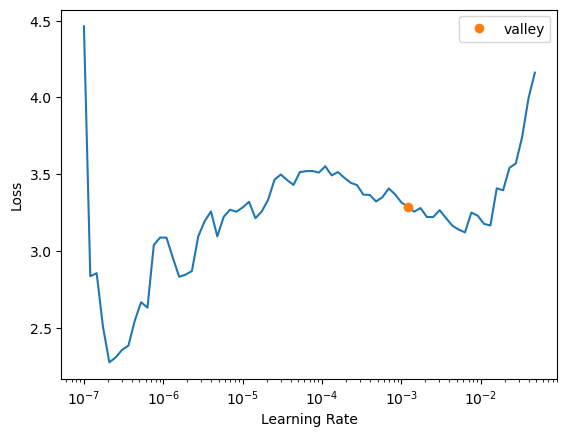

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.067372,6.296968,9.240744,15.581492,5.710312,21116.205390,59.695730,27.834809,0.661148,0.963302,01:50


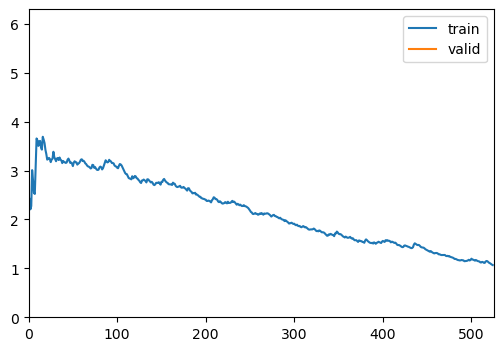

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.517530,0.318165,8.774904,13.801663,3.420710,21115.424023,56.556070,22.983790,0.144764,0.142999,01:50
1,0.328319,0.916991,7.280924,13.953948,5.244770,21115.112616,59.957488,22.842073,0.298979,0.481202,01:50
2,0.231499,0.137343,3.290414,5.234074,3.457513,21115.651766,42.426650,11.760500,0.112863,0.180186,01:50
3,0.173792,0.087080,5.866953,7.253912,4.930513,21115.328562,34.250403,9.468819,0.052987,0.157693,01:50
4,0.170667,0.084180,5.712739,7.618715,4.540581,21115.596681,34.987901,9.581450,0.052643,0.154186,01:50


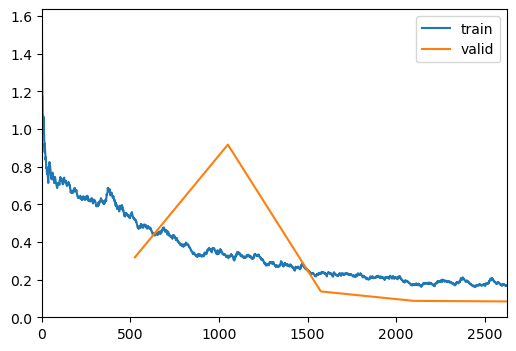

In [17]:
learn.fine_tune(5, 0.001, cbs= [ShowGraphCallback()])